In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import folium
import datetime
import numpy as np
import pandas as pd
import re
from pytz import timezone
import pytz

In [2]:
def decode_lat_lon(sr: pd.Series) -> pd.Series:
    """
    緯度経度を度数に変換
    dddmm.mmmm
    """
    tmp = sr.astype(float)
    return (tmp / 100).astype(int) + (tmp % 100) / 60

In [3]:
# LOG = "matsumoto-nagano-100318.log"
LOG = "nagano-matsumoto-100318.log"

gps_table = []

gpgga_list = [None] * 13
gprmc_list = [None] * 9

with open(LOG) as f:
    for line in f:
        str_list = line.split(",")
        if str_list[0] == "$GPGGA":
            gpgga_list = str_list[1:-1]
        elif str_list[0] == "$GPRMC":
            gprmc_list = str_list[1:-3]
            if gpgga_list[0] != gprmc_list[0]:
                print(gpgga_list, gprmc_list)
                gpgga_list = [None] * 13
            elif gpgga_list[1:5] != gprmc_list[2:6]:
                print(gpgga_list, gprmc_list)
                gpgga_list = [None] * 13
            gps_table.append(gprmc_list + gpgga_list[5:])
gps_df = pd.DataFrame(gps_table, columns=[
    "time", "status", "lat", "NS", "lon", "EW",
    "knots", "direction", "date", "quality", "sat",
    "harr", "elevation", "em", "geoid", "gm", "drp_id"
])
gps_df

[None, None, None, None, None, None, None, None, None, None, None, None, None] ['012258', 'A', '3637.9008', 'N', '13811.3569', 'E', '000.3', '004.3', '180310']


,time,status,lat,NS,lon,EW,knots,direction,date,quality,sat,harr,elevation,em,geoid,gm,drp_id
0,012258,A,3637.9008,N,13811.3569,E,000.3,004.3,180310,None,None,None,None,None,None,None,None
1,012312,A,3637.8827,N,13811.4093,E,000.1,060.2,180310,1,05,02.5,00351.5,M,037.4,M,00
2,012327,A,3637.8844,N,13811.4088,E,000.1,173.3,180310,1,05,02.5,00354.3,M,037.4,M,00
3,012342,A,3637.8847,N,13811.4086,E,000.1,041.5,180310,1,05,02.5,00360.4,M,037.4,M,00
4,012357,A,3637.8881,N,13811.4069,E,000.3,141.1,180310,1,04,06.3,00356.6,M,037.4,M,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,030709,A,3614.3477,N,13758.3616,E,015.8,101.6,180310,1,08,01.0,00597.8,M,037.4,M,00
406,030724,A,3614.3345,N,13758.4639,E,021.7,097.3,180310,1,07,01.2,00599.5,M,037.4,M,00
407,030739,A,3614.3176,N,13758.5716,E,019.7,104.9,180310,1,08,01.0,00595.7,M,037.4,M,00
408,030754,A,3614.3228,N,13758.6188,E,003.9,109.1,180310,1,07,01.2,00604.5,M,037.4,M,00


In [4]:
gps_df["lat_deg"] = decode_lat_lon(gps_df["lat"])
gps_df["lon_deg"] = decode_lat_lon(gps_df["lon"])
gps_df["lat"] = gps_df["lat"] * ((gps_df.pop("NS") == "N") * 2 - 1)
gps_df["lon"] = gps_df["lon"] * ((gps_df.pop("EW") == "E") * 2 - 1)

gps_df["lat"] = np.deg2rad(gps_df["lat_deg"])
gps_df["lon"] = np.deg2rad(gps_df["lon_deg"])

gps_df["quality"] = gps_df["quality"].astype(pd.Int64Dtype())
gps_df["sat"] = gps_df["sat"].astype(pd.Int64Dtype())
gps_df["drp_id"] = gps_df["drp_id"].astype(pd.Int64Dtype())
gps_df["knots"] = gps_df["knots"].astype(float)
gps_df["direction"] = gps_df["direction"].astype(float)
gps_df["harr"] = gps_df["harr"].astype(float)
gps_df["elevation"] = gps_df["elevation"].astype(float)
gps_df["geoid"] = gps_df["geoid"].astype(float)
gps_df["date"] = (gps_df["date"] + gps_df["time"]).apply(lambda x: pytz.timezone("UTC").localize(
    datetime.datetime.strptime(x, "%d%m%y%H%M%S")).astimezone(timezone("Asia/Tokyo")))

gps_df = gps_df.drop(["em", "gm", "time"], axis=1)

gps_df

,status,lat,lon,knots,direction,date,quality,sat,harr,elevation,geoid,drp_id,lat_deg,lon_deg
0,A,0.639343,2.411858,0.3,4.3,2010-03-18 10:22:58+09:00,<NA>,<NA>,NaN,NaN,NaN,<NA>,36.631680,138.189282
1,A,0.639338,2.411873,0.1,60.2,2010-03-18 10:23:12+09:00,1,5,2.5,351.5,37.4,0,36.631378,138.190155
2,A,0.639339,2.411873,0.1,173.3,2010-03-18 10:23:27+09:00,1,5,2.5,354.3,37.4,0,36.631407,138.190147
3,A,0.639339,2.411873,0.1,41.5,2010-03-18 10:23:42+09:00,1,5,2.5,360.4,37.4,0,36.631412,138.190143
4,A,0.639340,2.411873,0.3,141.1,2010-03-18 10:23:57+09:00,1,4,6.3,356.6,37.4,0,36.631468,138.190115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,A,0.632492,2.408078,15.8,101.6,2010-03-18 12:07:09+09:00,1,8,1.0,597.8,37.4,0,36.239128,137.972693
406,A,0.632488,2.408108,21.7,97.3,2010-03-18 12:07:24+09:00,1,7,1.2,599.5,37.4,0,36.238908,137.974398
407,A,0.632483,2.408139,19.7,104.9,2010-03-18 12:07:39+09:00,1,8,1.0,595.7,37.4,0,36.238627,137.976193
408,A,0.632485,2.408153,3.9,109.1,2010-03-18 12:07:54+09:00,1,7,1.2,604.5,37.4,0,36.238713,137.976980


In [5]:
fig = folium.Figure()

center_lat = 36.45
center_lon = 138.0

m = folium.Map([center_lat, center_lon], zoom_start=10).add_to(fig)
for i in gps_df.index:
    folium.Marker(location=[gps_df["lat_deg"][i], gps_df["lon_deg"][i]]).add_to(m)
m

In [6]:
use_columns = ["lat", "lon", "knots", "date", "elevation", "geoid"]

lat_lon_df = gps_df[use_columns][1:].copy() # 先頭削除
lat_lon_df_prev = gps_df[use_columns][:-1].copy() # 末尾削除

for uc in use_columns:
    lat_lon_df[uc + "_prev"] = list(lat_lon_df_prev[uc])
    
lat_lon_df

,lat,lon,knots,date,elevation,geoid,lat_prev,lon_prev,knots_prev,date_prev,elevation_prev,geoid_prev
1,0.639338,2.411873,0.1,2010-03-18 10:23:12+09:00,351.5,37.4,0.639343,2.411858,0.3,2010-03-18 10:22:58+09:00,NaN,NaN
2,0.639339,2.411873,0.1,2010-03-18 10:23:27+09:00,354.3,37.4,0.639338,2.411873,0.1,2010-03-18 10:23:12+09:00,351.5,37.4
3,0.639339,2.411873,0.1,2010-03-18 10:23:42+09:00,360.4,37.4,0.639339,2.411873,0.1,2010-03-18 10:23:27+09:00,354.3,37.4
4,0.639340,2.411873,0.3,2010-03-18 10:23:57+09:00,356.6,37.4,0.639339,2.411873,0.1,2010-03-18 10:23:42+09:00,360.4,37.4
5,0.639340,2.411872,0.2,2010-03-18 10:24:12+09:00,358.6,37.4,0.639340,2.411873,0.3,2010-03-18 10:23:57+09:00,356.6,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...
405,0.632492,2.408078,15.8,2010-03-18 12:07:09+09:00,597.8,37.4,0.632495,2.408060,4.8,2010-03-18 12:06:54+09:00,599.0,37.4
406,0.632488,2.408108,21.7,2010-03-18 12:07:24+09:00,599.5,37.4,0.632492,2.408078,15.8,2010-03-18 12:07:09+09:00,597.8,37.4
407,0.632483,2.408139,19.7,2010-03-18 12:07:39+09:00,595.7,37.4,0.632488,2.408108,21.7,2010-03-18 12:07:24+09:00,599.5,37.4
408,0.632485,2.408153,3.9,2010-03-18 12:07:54+09:00,604.5,37.4,0.632483,2.408139,19.7,2010-03-18 12:07:39+09:00,595.7,37.4


### [国土地理院の計算方法](https://vldb.gsi.go.jp/sokuchi/surveycalc/surveycalc/algorithm/bl2st/bl2st.htm)

In [7]:
def calc_dist_kokudo(phi1, L1, phi2, L2):
    """
    引数は (緯度1, 経度1, 緯度2, 経度2)
    いずれも弧度法であること前提
    """
    # GRS80楕円体
    a = 6378.137 # 長半径 (km)
    f = 1 / 298.257222101 # 扁平率

    exception_zones = ("2", "3a", "3b1")

    l = L2 - L1
    if l > np.pi:
        l_prime = l - 2 * np.pi
    elif l < -np.pi:
        l_prime = l + 2 * np.pi
    else:
        l_prime = l
    L = abs(l_prime)
    L_prime = np.pi - L
    if l_prime >= 0:
        u1 = np.arctan((1 - f) * np.tan(phi1))
        u2 = np.arctan((1 - f) * np.tan(phi2))
        delta = phi2 - phi1
    else:
        u1 = np.arctan((1 - f) * np.tan(phi2))
        u2 = np.arctan((1 - f) * np.tan(phi1))
        delta = phi1 - phi2
    SIGMA = phi1 + phi2
    SIGMA_prime = u1 + u2
    delta_prime = u2 - u1
    xi = np.cos(SIGMA_prime / 2)
    xi_prime = np.sin(SIGMA_prime / 2)
    eta = np.sin(delta_prime / 2)
    eta_prime = np.cos(delta_prime / 2)
    
    x = np.sin(u1) * np.sin(u2)
    y = np.cos(u1) * np.cos(u2)
    c = y * np.cos(L) + x
    epsilon = f * (2 - f) / (1 - f) ** 2
    
    if c >= 0:
        theta = L * (1 + f * y)
        zone = "1"
        
    if zone != "1":
        print("未実装")
        return -1
    F = 1
    while abs(F) >= 1e-15:
        if zone in exception_zones:
            g = np.sqrt((eta * np.sin(theta / 2)) ** 2 + (xi * np.cos(theta / 2)) ** 2)
            h = np.sqrt((eta_prime * np.sin(theta / 2)) ** 2 + (xi_prime * np.cos(theta / 2)) ** 2)
        else:
            g = np.sqrt((eta * np.cos(theta / 2)) ** 2 + (xi * np.sin(theta / 2)) ** 2)
            h = np.sqrt((eta_prime * np.cos(theta / 2)) ** 2 + (xi_prime * np.sin(theta / 2)) ** 2)
        
        sigma = 2 * np.arctan(g / h)
        J = 2 * g * h
        K = h ** 2 - g ** 2
        gamma = y * np.sin(theta) / J
        GAMMA = 1 - gamma ** 2
        zeta = GAMMA * K - 2 * x
        zeta_prime = zeta + x
        D = f * (1 + f) / 4 - 3 * f ** 2 * GAMMA / 16
        E = (1 - D * GAMMA) * f * gamma * (sigma + D * J * (zeta + D * K * (2 * zeta ** 2 - GAMMA ** 2)))
        if zone in exception_zones:
            F = theta - L_prime + E
        else:
            F = theta - L - E
        G = f * gamma ** 2 * (1 - 2 * D * GAMMA) + f * zeta_prime * (sigma / J) * (1 - D * GAMMA + f * gamma ** 2 / 2)\
            + f ** 2 * zeta * zeta_prime / 4
        theta = theta - F / (1 - G)
#         print(F, theta)
    
    n0 = epsilon * GAMMA / (np.sqrt(1 + epsilon * GAMMA) + 1) ** 2
    A = (1 + n0) * (1 + 5 * n0 ** 2 / 4)
    B = epsilon * (1 - 3 * n0 ** 2 / 8) / (np.sqrt(1 + epsilon * GAMMA) + 1) ** 2
    s = (1 - f) * a * A * (sigma - B * J * (zeta - B * (K * (GAMMA ** 2 - 2 * zeta ** 2)\
        - B * zeta * (1 - 4 * K ** 2) * (3 * GAMMA ** 2 - 4 * zeta ** 2) / 6) / 4))
    return s

### [ヒュベニの公式](https://www.trail-note.net/tech/calc_distance/)

In [8]:
def calc_dist_hubeny(lat1, lon1, lat2, lon2):
    Rx = 6378.137 # 長半径 (km)
    Ry = 6356.752314245 # 短半径(km)
    E = np.sqrt((Rx ** 2 - Ry ** 2) / Rx ** 2) # 第一離心率
    
    P = (lat1 + lat2) / 2
    W = np.sqrt(1 - E ** 2 * np.sin(P) ** 2)
    M = Rx * (1 - E ** 2) / (W ** 3) # 子午線曲率半径
    N = Rx / W # 卯酉線曲率半径
    Dy = lat2 - lat1
    Dx = lon2 - lon1
    return np.sqrt((Dy * M) ** 2 + (Dx * N * np.cos(P)) ** 2)

### 球の接平面近似

In [9]:
def calc_dist_tangent(lat1, lon1, lat2, lon2):
    # 地球の長半径 (km)
    # r = 6378.137
    # 地球の極半径
    r = 6356.752

    # 緯度の最大値 (距離は最小値)
    example_lat = gps_df["lat"].max()
    # example_lat = gps_df["lat"].mean()

    return r * np.sqrt((lat1 - lat2) ** 2 + ((lon1 - lon2) * np.cos(example_lat)) ** 2)
# print(f"地球の半径: {R}, 緯度の代表値: {example_lat:.4f}")

### 球面近似と楕円体高

In [10]:
# 地球の長半径 (km)
R = 6378.137
# 地球の極半径
# R = 6356.752

# 簡単化のため欠損値除去
df2 = gps_df.dropna()

# 各点の半径
local_R = (df2["elevation"] + df2["geoid"]) / 1000 + R

x = np.cos(df2["lat"]) * np.cos(df2["lon"]) * local_R
y = np.cos(df2["lat"]) * np.sin(df2["lon"]) * local_R
z = np.sin(df2["lat"]) * local_R

df_3d = pd.DataFrame({"x": x, "y": y, "z": z})

use_columns = list(df_3d.columns)

df_3d_mem = df_3d[use_columns][1:].copy() # 先頭削除
df_3d_prev = df_3d[use_columns][:-1].copy() # 末尾削除

for uc in use_columns:
    df_3d_mem[uc + "_prev"] = list(df_3d_prev[uc])

df_3d_mem["dist_3d"] = np.sqrt(
    (df_3d_mem["x"] - df_3d_mem["x_prev"]) ** 2 + 
    (df_3d_mem["y"] - df_3d_mem["y_prev"]) ** 2 + 
    (df_3d_mem["z"] - df_3d_mem["z_prev"]) ** 2
)

df_3d_mem

,x,y,z,x_prev,y_prev,z_prev,dist_3d
2,-3815.287845,3412.441867,3805.843867,-3815.288069,3412.441069,3805.839665,0.004283
3,-3815.291047,3412.445131,3805.847954,-3815.287845,3412.441867,3805.843867,0.006133
4,-3815.284281,3412.442475,3805.850749,-3815.291047,3412.445131,3805.847954,0.007787
5,-3815.283541,3412.446208,3805.851495,-3815.284281,3412.442475,3805.850749,0.003878
6,-3815.267423,3412.439982,3805.861672,-3815.283541,3412.446208,3805.851495,0.020054
...,...,...,...,...,...,...,...
405,-3821.721592,3444.393051,3770.853399,-3821.651999,3444.454837,3770.869523,0.094450
406,-3821.835863,3444.289935,3770.834649,-3821.721592,3444.393051,3770.853399,0.155056
407,-3821.955260,3444.180558,3770.807111,-3821.835863,3444.289935,3770.834649,0.164248
408,-3822.003583,3444.129015,3770.820095,-3821.955260,3444.180558,3770.807111,0.071836


### 区分求積法

In [11]:
# 地球の長半径 (km)
R = 6378.137

lat_lon_df["lat_mean"] = (lat_lon_df["lat"] + lat_lon_df["lat_prev"]) / 2.0
delta_lat = lat_lon_df["lat"] - lat_lon_df["lat_prev"]
delta_lon = lat_lon_df["lon"] - lat_lon_df["lon_prev"]

d = np.sqrt(delta_lat ** 2 + (delta_lon * np.cos(lat_lon_df["lat_mean"])) ** 2)
delta_seconds = (lat_lon_df["date"] - lat_lon_df["date_prev"]).apply(lambda x: x.total_seconds())

# 平均移動速度からknotsを計算
lat_lon_df["average_knots"] = d / np.pi / delta_seconds * 3.888e7

lat_lon_df["dist_quad"] = lat_lon_df["knots"] * np.pi * delta_seconds * R / 3.888e7
print(lat_lon_df["dist_quad"].sum())
lat_lon_df

71.21530427816315


,lat,lon,knots,date,elevation,geoid,lat_prev,lon_prev,knots_prev,date_prev,elevation_prev,geoid_prev,lat_mean,average_knots,dist_quad
1,0.639338,2.411873,0.1,2010-03-18 10:23:12+09:00,351.5,37.4,0.639343,2.411858,0.3,2010-03-18 10:22:58+09:00,NaN,NaN,0.639341,11.772115,0.000722
2,0.639339,2.411873,0.1,2010-03-18 10:23:27+09:00,354.3,37.4,0.639338,2.411873,0.1,2010-03-18 10:23:12+09:00,351.5,37.4,0.639338,0.419211,0.000773
3,0.639339,2.411873,0.1,2010-03-18 10:23:42+09:00,360.4,37.4,0.639339,2.411873,0.1,2010-03-18 10:23:27+09:00,354.3,37.4,0.639339,0.081656,0.000773
4,0.639340,2.411873,0.3,2010-03-18 10:23:57+09:00,356.6,37.4,0.639339,2.411873,0.1,2010-03-18 10:23:42+09:00,360.4,37.4,0.639339,0.879237,0.002319
5,0.639340,2.411872,0.2,2010-03-18 10:24:12+09:00,358.6,37.4,0.639340,2.411873,0.3,2010-03-18 10:23:57+09:00,356.6,37.4,0.639340,0.429788,0.001546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,0.632492,2.408078,15.8,2010-03-18 12:07:09+09:00,597.8,37.4,0.632495,2.408060,4.8,2010-03-18 12:06:54+09:00,599.0,37.4,0.632494,12.215574,0.122142
406,0.632488,2.408108,21.7,2010-03-18 12:07:24+09:00,599.5,37.4,0.632492,2.408078,15.8,2010-03-18 12:07:09+09:00,597.8,37.4,0.632490,20.054416,0.167752
407,0.632483,2.408139,19.7,2010-03-18 12:07:39+09:00,595.7,37.4,0.632488,2.408108,21.7,2010-03-18 12:07:24+09:00,599.5,37.4,0.632486,21.238862,0.152291
408,0.632485,2.408153,3.9,2010-03-18 12:07:54+09:00,604.5,37.4,0.632483,2.408139,19.7,2010-03-18 12:07:39+09:00,595.7,37.4,0.632484,9.221568,0.030149


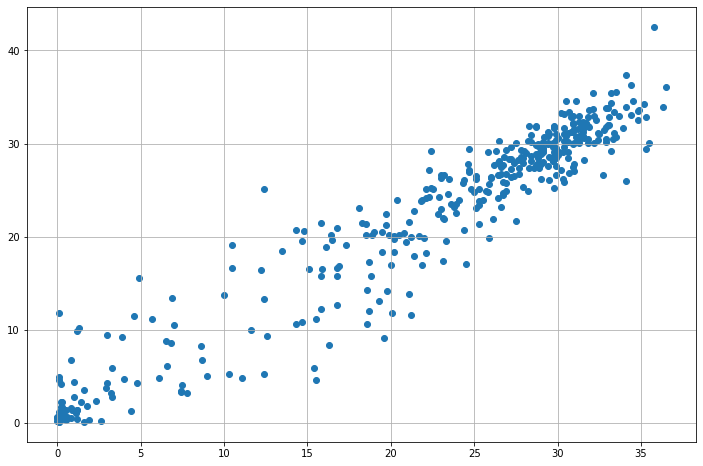

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.scatter(lat_lon_df["knots"], lat_lon_df["average_knots"])
ax.grid()
plt.show()

In [13]:
dist_list_kokudo = []
dist_list_tangent = []
dist_list_hubeny = []

for idx, sr in lat_lon_df.iterrows():
    dist_list_kokudo.append(calc_dist_kokudo(sr["lat"], sr["lon"], sr["lat_prev"], sr["lon_prev"]))
    dist_list_tangent.append(calc_dist_tangent(sr["lat"], sr["lon"], sr["lat_prev"], sr["lon_prev"]))
    dist_list_hubeny.append(calc_dist_hubeny(sr["lat"], sr["lon"], sr["lat_prev"], sr["lon_prev"]))
    
lat_lon_df["dist_kokudo"] = dist_list_kokudo
lat_lon_df["dist_tangent"] = dist_list_tangent
lat_lon_df["dist_hubeny"] = dist_list_hubeny

lat_lon_df["dist_3d"] = df_3d_mem["dist_3d"]

lat_lon_df

,lat,lon,knots,date,elevation,geoid,lat_prev,lon_prev,knots_prev,date_prev,elevation_prev,geoid_prev,lat_mean,average_knots,dist_quad,dist_kokudo,dist_tangent,dist_hubeny,dist_3d
1,0.639338,2.411873,0.1,2010-03-18 10:23:12+09:00,351.5,37.4,0.639343,2.411858,0.3,2010-03-18 10:22:58+09:00,NaN,NaN,0.639341,11.772115,0.000722,0.084982,0.084651,0.084982,NaN
2,0.639339,2.411873,0.1,2010-03-18 10:23:27+09:00,354.3,37.4,0.639338,2.411873,0.1,2010-03-18 10:23:12+09:00,351.5,37.4,0.639338,0.419211,0.000773,0.003231,0.003230,0.003231,0.004283
3,0.639339,2.411873,0.1,2010-03-18 10:23:42+09:00,360.4,37.4,0.639339,2.411873,0.1,2010-03-18 10:23:27+09:00,354.3,37.4,0.639339,0.081656,0.000773,0.000630,0.000629,0.000630,0.006133
4,0.639340,2.411873,0.3,2010-03-18 10:23:57+09:00,356.6,37.4,0.639339,2.411873,0.1,2010-03-18 10:23:42+09:00,360.4,37.4,0.639339,0.879237,0.002319,0.006780,0.006774,0.006780,0.007787
5,0.639340,2.411872,0.2,2010-03-18 10:24:12+09:00,358.6,37.4,0.639340,2.411873,0.3,2010-03-18 10:23:57+09:00,356.6,37.4,0.639340,0.429788,0.001546,0.003326,0.003311,0.003326,0.003878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,0.632492,2.408078,15.8,2010-03-18 12:07:09+09:00,597.8,37.4,0.632495,2.408060,4.8,2010-03-18 12:06:54+09:00,599.0,37.4,0.632494,12.215574,0.122142,0.094527,0.093659,0.094527,0.094450
406,0.632488,2.408108,21.7,2010-03-18 12:07:24+09:00,599.5,37.4,0.632492,2.408078,15.8,2010-03-18 12:07:09+09:00,597.8,37.4,0.632490,20.054416,0.167752,0.155196,0.153748,0.155196,0.155056
407,0.632483,2.408139,19.7,2010-03-18 12:07:39+09:00,595.7,37.4,0.632488,2.408108,21.7,2010-03-18 12:07:24+09:00,599.5,37.4,0.632486,21.238862,0.152291,0.164354,0.162838,0.164354,0.164248
408,0.632485,2.408153,3.9,2010-03-18 12:07:54+09:00,604.5,37.4,0.632483,2.408139,19.7,2010-03-18 12:07:39+09:00,595.7,37.4,0.632484,9.221568,0.030149,0.071365,0.070695,0.071365,0.071836


In [14]:
lat_lon_df.filter(regex=r'dist', axis=1).sum()

dist_quad       71.215304
dist_kokudo     70.676811
dist_tangent    70.486193
dist_hubeny     70.676811
dist_3d         70.990123
dtype: float64

### 3次元プロット

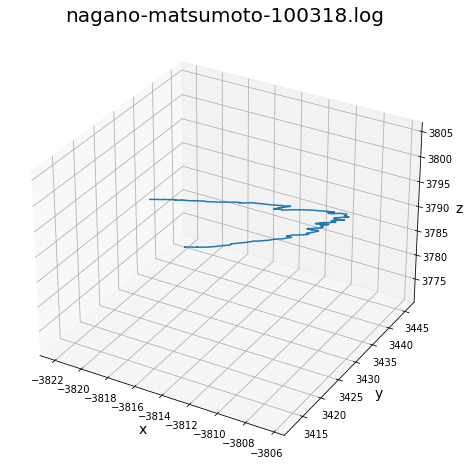

In [15]:
# Figureを追加
fig = plt.figure(figsize = (8, 8))

# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')
# Axesのタイトルを設定
ax.set_title(LOG, size = 20)

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("z", size = 14)

# 曲線を描画
ax.plot(x, y, z)

plt.show()

### できるだけxy平面になるように回転

In [16]:
example_lat = gps_df["lat"].mean()
example_lon = gps_df["lon"].mean()

# 本初子午線あたりに移動
rot_matrix1 = np.matrix([
    [np.cos(example_lon), np.sin(example_lon), 0],
    [-np.sin(example_lon), np.cos(example_lon), 0],
    [0, 0, 1]
])

# 北極あたりに移動
rot_matrix2 = np.matrix([
    [np.sin(example_lat), 0, -np.cos(example_lat)],
    [0, 1, 0],
    [np.cos(example_lat), 0, np.sin(example_lat)]
])

rot_matrix = rot_matrix2 * rot_matrix1
print("回転行列")
print(rot_matrix)

xyz_matrix = np.matrix(df_3d).T
xyz_matrix_rotated = rot_matrix * xyz_matrix
df_3d_rotated = pd.DataFrame(xyz_matrix_rotated.T, columns=["x", "y", "z"])

# 高さを最小値基準とする
df_3d_rotated_mapped = df_3d_rotated.copy()
df_3d_rotated_mapped["z"] -= df_3d_rotated["z"].min()
df_3d_rotated_mapped

回転行列
[[-0.44188084  0.39768389 -0.80410748]
 [-0.66895649 -0.74330156  0.        ]
 [-0.59769435  0.53791292  0.59448394]]


,x,y,z
0,-17.328625,15.788947,0.019622
1,-17.331785,15.788203,0.022416
2,-17.332358,15.787920,0.028515
3,-17.338651,15.785367,0.024704
4,-17.338094,15.782098,0.026714
...,...,...,...
404,26.353733,-3.657265,0.253514
405,26.378296,-3.504176,0.255198
406,26.409702,-3.343004,0.251355
407,26.400116,-3.272367,0.260231


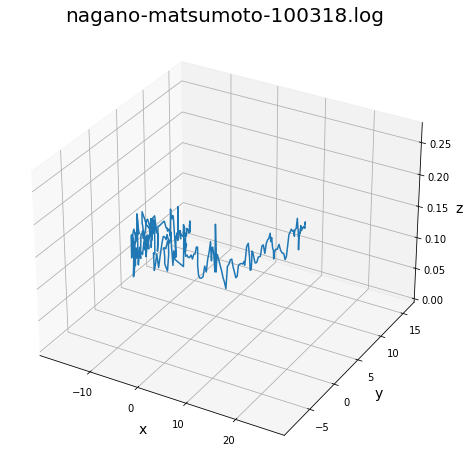

In [17]:
# Figureを追加
fig = plt.figure(figsize = (8, 8))

# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')
# Axesのタイトルを設定
ax.set_title(LOG, size = 20)

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("z", size = 14)

# 曲線を描画
ax.plot(*df_3d_rotated_mapped.values.T.tolist())

plt.show()